# これなに？


ふだん、広告分野での機械学習を開発している長谷川といいます。  
Web広告では一日に膨大な量のリクエストを受けるとともに、その特徴量の種類も非常に豊富なため、どうしても使用メモリ量や実行時間がボトルネックになることが多々あります。  
そのため、日々細かい改善を繰り返しながら、システムを改善してくことが求められるのですが、その際に`scipy.sparse`の性質を利用することで、実行時間を改善できたことが多々があったので、そのうちから応用例をいくつかを紹介します。

## scipy.sparseとは?
ざっくりいうと、疎である行列のメモリの持ち方を効率化するためのモジュールです。持ち方は、行いたい処理の性質に応じて、行指向の`csr形式`や列指向`csc形式`など、多々あるのですが、今回は**`coo形式(座標形式)`**の性質を利用して、処理を効率化します。

## COOの性質
1. `coo`は行列の要素を(行,列)のタプルで指定し、指定しなかったものは0になるという性質があります。

In [35]:
from scipy.sparse import coo_matrix
import numpy as np

value=np.ones(3)
row = np.array([0,1,2])
col = np.array([0,1,2])

mat=coo_matrix((value,(row,col)))
print(f'coo:{mat.toarray()}')

coo:[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


上のように、座標形式で指定した要素のみが1となりました。

2. さらに、`coo_matrix`は同じ座標を指定すると要素が加算される性質があります。

In [36]:
value=np.ones(4)
row = np.array([0,1,1,2])
col = np.array([0,1,1,2])

mat=coo_matrix((value,(row,col)))
print(f'coo:{mat.toarray()}')

coo:[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]


同じ座標で指定されている`(1,1)`の要素のみが加算さて2になりました  
この２つの性質を利用して、処理を効率化できる例を見ていきます。

# 応用例

## バージョン
- Python 3.7.1
- numpy==1.15.4
- pandas==0.23.4
- scikit-learn==0.20.1
- scipy==1.1.0

## 1. 大量のデータをダミー化する
１つ目の例としては、大量のカテゴリデータをダミー化する場合です。  
仮のデータには`titanic`データの`embark_town`特徴量を使用します。

In [76]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import coo_matrix 
from seaborn.utils import load_dataset

# ダミー化したいデータ
x=load_dataset('titanic')['embark_town']
x=x.fillna('NaN')

# 見やすくするためDataFrameに変換
pd.DataFrame(x.head())

,embark_town
0,Southampton
1,Cherbourg
2,Southampton
3,Southampton
4,Southampton


`pandas.factorize`でindexに変換します

In [78]:
# 追加でdummy化するデータと整合性を保つためsortしておく
x_index,category=pd.factorize(x,sort=True) 
x_index[:10]

array([3, 0, 3, 3, 3, 2, 3, 3, 3, 0])

欠損値も含めてカテゴリは以下のようになりました。

In [79]:
category

Index(['Cherbourg', 'NaN', 'Queenstown', 'Southampton'], dtype='object')

ここから、`coo_matrix`の性質を利用します。  
`coo_matrix`をインスタンス化する際に必要な引数のタプルの第一要素に、座標に対応した(0ではない)要素の値を行列で
指定するわけですが、ここは、全て1かつ、ただの`view`で構わないので、`numpy.broadcast_to`を使って、無駄なメモリを使用しないように効率化します

In [80]:
x_size=len(x_index)
row=np.arange(x_size)
x_coo=coo_matrix((np.broadcast_to(1,x_size),(row,x_index)))

`numpy.array`型に変化して中身をチェックしてみます。

In [82]:
x_coo.toarray()[:10]

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

無事できました。

ついでに、後でデータを追加したい場合にどうするかも考えます  
ただし、簡単のため、追加するデータの特徴量のカテゴリは上の例と同じであるとします

In [83]:
# 追加するデータ
add=np.random.choice(category,100)
add[:10]

array(['NaN', 'Southampton', 'Cherbourg', 'Cherbourg', 'Southampton',
       'NaN', 'Southampton', 'NaN', 'Southampton', 'Cherbourg'],
      dtype=object)

In [84]:
# 同じようにダミー化
add_index,_=pd.factorize(add,sort=True)

add_size=len(add_index)
add_row=np.arange(add_size)
add_coo=coo_matrix((np.broadcast_to(1,add_size),(add_row,add_index)))

In [85]:
add_coo.toarray()[:10]

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

くっつけます

In [86]:
from scipy.sparse import vstack
all_coo=vstack((x_coo,add_coo))
all_coo.shape

(991, 4)

あとからデータを追加できました

最後に、本当正しくにダミー化できているのか確認するため、`pd.get_dummies`を使用した場合と結果が同じか確認します

In [87]:
all_dummied=pd.get_dummies(np.concatenate((x,add)))                      
(all_coo.toarray()==all_dummied.values).all()

True

全く同じ結果になってますね

### パフォーマンス
重要なのは、実行時間が本当に短くなっているかです、そのため、以下のように100000個のデータでダミー化する場合について、比較してみます

In [88]:
# 巨大なデータセットを作成
import itertools as it
test_data=np.random.choice(x,100000)
test_data.shape

(100000,)

Jupyterのマジックコマンドを使って実行時間を比べてみます

### pandas.get_dummiesを使用した場合

In [89]:
%timeit pd.get_dummies(test_data)

5.47 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### sparse.coo_matrixを応用する場合

In [90]:
%%timeit
x_index,_=pd.factorize(x,sort=True)
x_size=len(x_index)
row=np.arange(x_size)
x_coo=coo_matrix((np.broadcast_to(1,x_size),(row,x_index))).toarray()

401 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


圧倒的に`coo`形式で変換したほうが速いです。  
ちなみに、`pandas.get_duumies`のオプションの`sparse`というのがありますが、`True`にすると返り値の型が`SparseDataFrame`になるので、諸々要注意です(少なくとも実行時間がさらに遅くなります)

## 2. 大量のデータから混同行列を作成する

別例として、加算される性質を利用して、混同行列(confusion matrix)を生成する応用例も上げます

In [91]:
# 利用するデータ
N=100000
rng = np.random.RandomState(1)

data1=rng.randint(0,10,size=N)
data2=rng.randint(0,10,size=N)

### scikit-learnのcofusion_matrixを使った場合

まず、`sparse`を使わない標準的なやり方でやってみます

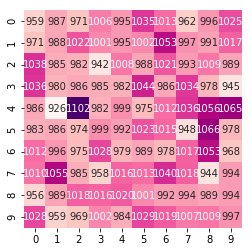

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_sk=confusion_matrix(data1,data2)

sns.heatmap(mat_sk.T, square=True, annot=True, fmt='d', cbar=False, cmap='RdPu')

### coo_matrixを使った場合

coo_matrixを使って同じ混同行列を作成してみます

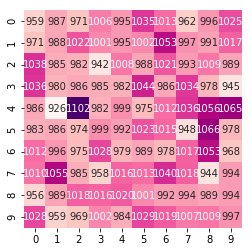

In [93]:
mat_coo=coo_matrix((np.broadcast_to(1,N),(data1,data2)))

sns.heatmap(mat_coo.toarray().T, square=True, annot=True, fmt='d', cbar=False, cmap='RdPu')

全く同じ混同行列が作成できました

### パフォーマンス
実行時間にどれ位の差がでるかも確認してみます

In [95]:
# scikit-learnのconfusion_matrixを使用
%timeit mat_sk=confusion_matrix(data1,data2)

81.1 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
# coo_matrixを使用
%timeit mat_coo=coo_matrix((np.broadcast_to(1,N),(data1,data2))).toarray()

924 µs ± 7.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


前の例と同じように、`coo_matrix`を使用したほうが圧倒的に速いですね。

# 感想とか

`sparse_matrix`の性質をうまく利用すると、大量のデータにおけるデータ分析が格段に速くなることがあってとても便利になることがわかりました。 データ量が多くなれば多くなるほど、`scipy.sparse`を使用したほうが処理は効率化できます。
ただし、`sparse_matrix`の性質を十分知った上で利用しないと、むしろ処理の速度を悪化させる場合もあるので、注意が執拗です。`scipy.sparse`の他の性質については[こちらの本](https://www.oreilly.co.jp/books/9784873118604/)にとてもよくまとまっていたので、もし興味があれば読んでみることをおすすめします。  
データ処理の効率化できる例はまだまだ他にもいくつかあるので、ぼそぼそ上げてければと思います。


# TODO 以下はあまり変わらなかったので、toolzの内容を一緒にしたほうが良いかも

## メモリ

`memory_profiler`を使用して計測します

In [99]:
!pip install memory_profiler

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


マジックコマンドが適用できるようにロードします

In [100]:
 %load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### pandas.get_dummiesを使用した場合

In [118]:
%mprun -f pd.get_dummies pd.get_dummies(test_data)

`sprse=True`にしても変わりません

In [112]:
%mprun -f pd.get_dummies  pd.get_dummies(test_data,sparse=True)

### sparse.coo_matrixを応用する場合

計測したいコードが複数行にまたがる場合、一度ファイルに書き出す必要がります。

In [107]:
%%file dummies_perfomance.py
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
def dummies_coo(x):
    x_index,_=pd.factorize(x,sort=True)
    x_size=len(x_index)
    row=np.arange(x_size)
    x_coo=coo_matrix((np.broadcast_to(1,x_size),(row,x_index)))
    

Overwriting dummies_perfomance.py


In [114]:
%reload_ext autoreload
%autoreload 2

In [113]:
from dummies_perfomance import dummies_coo
%mprun -f dummies_coo  dummies_coo(test_data)

# toolzを応用してストリーミング形式で変換していく

記事分けるかも

In [122]:
dist=np.random.rand()

In [124]:
dist

array([[0.55769951, 0.33657123],
       [0.45133011, 0.2789067 ],
       [0.50104486, 0.0466694 ],
       [0.82246099, 0.31585821],
       [0.73246399, 0.40975698],
       [0.45640806, 0.47895361],
       [0.00591605, 0.68231773],
       [0.46736764, 0.86555798],
       [0.56427689, 0.5840203 ],
       [0.05885119, 0.28730723]])

In [126]:
dist[:,np.newaxis,:].shape

(10, 1, 2)

In [127]:

dist[np.newaxis,:,:].shape

(1, 10, 2)

IndexError: list index out of range